# <div style=" text-align: center; font-weight: bold">Phase 02: Preprocessing data</div>

This is the preprocessing phase for data of the real estates for sale.

## **1. Import necessary Python modules**

In [795]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import unicodedata
import seaborn as sns

## **2. Explore the data**

### **2.1 Read the data from file**:

In [796]:
real_estate_for_sale_df = pd.read_csv('../Data/real_estate_for_sale.csv', encoding='utf-8')
real_estate_for_sale_df.head()

,Address,Type,Area,Price,Bedroom,Toilet,Floor,Furniture,Direction,Legal,Posting date,Expiry date,Ad type,Ad code
0,"Dự án Zenity, Đường Võ Văn Kiệt, Phường Cầu Kh...",Căn hộ chung cư,"161,08 m²","17,98 tỷ",3 phòng,3 phòng,NaN,Đầy đủ,Đông - Bắc,Sổ đỏ/ Sổ hồng,06/12/2023,13/12/2023,Tin VIP Kim Cương,38720367
1,"Dự án Zenity, Đường Võ Văn Kiệt, Phường Cầu Kh...",Căn hộ chung cư,116 m²,"9,8 tỷ",3 phòng,2 phòng,NaN,Đầy đủ,Đông - Bắc,Sổ đỏ/ Sổ hồng,03/12/2023,10/12/2023,Tin thường,38693652
2,"Dự án Zenity, Đường Võ Văn Kiệt, Phường Cầu Kh...",Căn hộ chung cư,77 m²,6 tỷ,2 phòng,2 phòng,NaN,Đầy đủ.,Đông - Nam,Sổ đỏ/ Sổ hồng,01/12/2023,11/12/2023,Tin VIP Kim Cương,38481731
3,"Dự án Lumiere Riverside, Đường Xa Lộ Hà Nội, P...",Căn hộ chung cư,76 m²,"6,2 tỷ",2 phòng,2 phòng,NaN,Đầy đủ,NaN,Hợp đồng mua bán,05/12/2023,12/12/2023,Tin VIP Kim Cương,38393009
4,"Dự án Zenity, Đường Võ Văn Kiệt, Phường Cầu Kh...",Căn hộ chung cư,95 m²,80 triệu/m²,2 phòng,2 phòng,NaN,Đầy đủ.,NaN,Sổ đỏ/ Sổ hồng.,07/12/2023,14/12/2023,Tin VIP Kim Cương,38734339


### **2.2 Some overview**:
#### **2.2.1 Num of rows and columns:**

In [797]:
num_rows, num_cols = real_estate_for_sale_df.shape

print(f'Num of rows:  {num_rows}')
print (f'Num of columns:  {num_cols}')

Num of rows:  55312
Num of columns:  14


#### **2.2.2 The meaning of each line. Is there any line with differenct meaning?**

- The data we used here is collected by crawling raw data from the website https://batdongsan.com.vn/        
- Each line is a record of a advertisement of real estate. So there isn't any line that has different meaning.

#### **2.2.3 Num of duplicated rows:**

In [798]:
duplicate = real_estate_for_sale_df.duplicated().sum()

print (f' Nums of duplicated rows: {duplicate}')

 Nums of duplicated rows: 266


We can see that there are duplicated rows in the dataset. The reasons here are some advertisements could be reposted in the website, or some errors during the data-collecting process may lead to the duplicated data.      
So, we will drop these duplicated rows, then reset the index of the dataframe.

In [799]:
real_estate_for_sale_df.drop_duplicates(inplace= True)
real_estate_for_sale_df = real_estate_for_sale_df.reset_index(drop=True)

#### **2.2.4 Ratio of missing values for each column:**
Next, we will find the missing ratio for each column in the dataset. This is necessary to determine the next steps we should do.

In [800]:
def missing_ratio(column):
    missing_values = column.isnull().sum()
    total_values = len(column)
    return (missing_values / total_values) * 100

missing_ratios_df = real_estate_for_sale_df.agg(missing_ratio).to_frame()
missing_ratios_df.columns = ['Missing ratio']

missing_ratios_df

,Missing ratio
Address,0.000000
Type,0.000000
Area,0.036333
Price,0.000000
Bedroom,38.362460
Toilet,42.279185
Floor,54.421756
Furniture,58.511063
Direction,78.234567
Legal,31.195727


- We can see that the fields `Address`, `Type`, `Price`, `Posting date`, `Expiry date`, `Ad type`, `Ad code` have no missing values. This is easy to understand the reasons: The `Address`, `Type` and `Price` is the basic data that a post have to contain. And three orther fields is the data that auto generated by the website.

- Beside that, fields like `Bedroom`, `Toilet`, `Floor`, `Furniture` are more special. The dataset contain many types of real easte, including categories such as `Đất nền dự án`, `Đất bán`, `Trang trại, khu nghỉ dưỡng`, these types of real easte may not have the information of above fields. So it is reasonable to expect that these fields will have missing values. We will consider it more clearly in the next part.

- The remaining fields have a large ratio of missing value. from *31.176588 %* in `Legal` up to *78.23849 %* in `Direction`. So the data preprocessing of data is so necessary before we make the analysis.

### **2.3 The meaning of each columns**
Let's see all the columns of the dataset.

In [801]:
real_estate_for_sale_df.columns.to_list()

['Address',
 'Type',
 'Area',
 'Price',
 'Bedroom',
 'Toilet',
 'Floor',
 'Furniture',
 'Direction',
 'Legal',
 'Posting date',
 'Expiry date',
 'Ad type',
 'Ad code']

- `Address`: address of the real estate. With the real estate is apartment, the address can also contain the Project of the real estate.
- `Type` : the category of the real estate.
- `Area`: the area of the real estate.
- `Price`: the price of the real estate. It can be the total price or just the price per m^2.
- `Bedroom`: number of bedroom in the real estate.
- `Toilet`: number of toilet in the real estate.
- `Floor`: number of floor.
- `Furniture`: the furniture status of the real estate.
- `Direction`: the direction of the real estate.
- `Legal`: Some legalities of the real estate.
- `Posting date`: The day that the advertisement was posted.
- `Expiry date`: the day the real estate was enable.
- `Ad type`: the type of advertisement.
- `Ad code`: the code of advertisement.

#### **2.3.1 Data type of each colmuns:**
Now, let's check the data type of each column

In [802]:
cols_type = real_estate_for_sale_df.dtypes
cols_type

Address         object
Type            object
Area            object
Price           object
Bedroom         object
Toilet          object
Floor           object
Furniture       object
Direction       object
Legal           object
Posting date    object
Expiry date     object
Ad type         object
Ad code          int64
dtype: object

- Nearly all of the columns is in Object type. These columns will not suitable for the further analysis. So we need to do some preprocessing on the data types.
- `Area`, `Price`, `Bedroom`, `Toilet` and `Floor` should be numerical columns, so we will convert them into numeric data types.
- `Posting date` should be in `datetime` type
- `Expiry date`, `Ad type`, `Ad code` is not so meaningful for our analysis, so we should remove it later.

After some overview about the dataset, Let's make some cleaning on it.
### **2.4 Preprocessing for numeric columns:**

#### **2.4.1. Area:**
First, let's make some quick view to this column:

In [803]:
real_estate_for_sale_df['Area'].to_frame()

,Area
0,"161,08 m²"
1,116 m²
2,77 m²
3,76 m²
4,95 m²
...,...
55041,144 m²
55042,140 m²
55043,66 m²
55044,63 m²


The column could contain many formats of area value, also the unit could not be consistent. We need to find that if the values is in the same unit?

In [804]:
area_values = real_estate_for_sale_df[real_estate_for_sale_df['Area'].notna()]['Area'].to_list()
unit_list = []

for area in area_values:
    unit_list.append(area.split(' ')[1])

set(unit_list)


{'m²'}

So we can see that all the values in columns `Area` is in the `m²` unit. Now we have to change the datas into the right format, then convert them to `float`. Finally, rename the column for a clearly meaning.

In [805]:

def clean_area(area):
    
    if pd.isna(area):
        return area
    
    area = area.split(' ')[0]
    if (',' in area) and ('.' in area):
        cleaned_area = area.replace('.', '').replace(',', '.')
    elif ',' in area:
        
        cleaned_area = area.replace(',', '.')
    else:
        # print (area)
        cleaned_area = area
    
    if '.' in area:
        count = len(area.split('.')[-1])
        if count == 3:
            cleaned_area = area.replace('.', '')
    
    return cleaned_area

real_estate_for_sale_df.loc[:,'Area'] = real_estate_for_sale_df.loc[:,'Area'].apply(clean_area)
real_estate_for_sale_df['Area'] = real_estate_for_sale_df['Area'].astype('float64')

# Drop the area that is nan
real_estate_for_sale_df = real_estate_for_sale_df[real_estate_for_sale_df['Area'].notna()]
real_estate_for_sale_df.rename(columns={'Area': 'Area(m2)'}, inplace=True)

In [806]:
real_estate_for_sale_df[(real_estate_for_sale_df['Type'] == 'Căn hộ chung cư') & (real_estate_for_sale_df['Area(m2)'] > 1000) ]

,Address,Type,Area(m2),Price,Bedroom,Toilet,Floor,Furniture,Direction,Legal,Posting date,Expiry date,Ad type,Ad code
27603,"The Everrich Infinity, 290, Đường An Dương Vươ...",Căn hộ chung cư,1030.0,75 tỷ,NaN,NaN,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,23/11/2023,08/12/2023,Tin thường,38497317


#### **2.4.2 Price:**
With `Price ` column, at first, we will find that if the values is in the same unit.

In [807]:

price_values = real_estate_for_sale_df['Price'].to_list()

unit_list = []
value_list = []
for price in price_values:
    unit_list.append(price.split(' ')[1])
    value_list.append(price.split(' ')[0])

set(unit_list)

{'nghìn/m²', 'thuận', 'triệu', 'triệu/m²', 'tỷ', 'tỷ/m²'}

The `Price` column contains various units, so we will convert them all to the `VNĐ` unit. With the price is `Thỏa thuận`, we will replace them with `NaN`

In [808]:
# raise ExceptionGroup("NotImplemented")
def update_price(price, area):
    new_price = 0

    if 'nghìn/m²' in price:
        new_price = float(price.split(' ')[0]) * area

    elif 'triệu' in price:
        new_price, unit = price.split(' ')
        if unit.strip() == 'triệu':
            new_price = float(new_price.replace(',', '.'))
            new_price *= 1000000
        elif unit.strip() == 'triệu/m²':
            new_price = float(new_price.replace(',', '.'))
            new_price *= area * 1000000

    elif 'tỷ' in price:
        new_price, unit = price.split(' ')
        if unit.strip() == 'tỷ/m²':
            new_price = float(new_price.replace(',', '.'))
            new_price *= area * 1000000000
        else:
            new_price = float(new_price.replace(',', '.'))
            new_price *= 1000000000
   
    return "{:0,.2f}".format(new_price) if new_price != 0 else np.nan


real_estate_for_sale_df['Price'] = real_estate_for_sale_df.apply(lambda row: update_price(row['Price'], row['Area(m2)']), axis=1)

real_estate_for_sale_df.rename(columns={'Price': 'Price(VNĐ)'}, inplace=True)


In [809]:
real_estate_for_sale_df['Price(VNĐ)'].isna().sum()

5715

#### **2.4.3 Bedroom, Toilet, Floor:**
With all three columns, we find that there are similiraties between them, so we can process all of them once.

In [810]:

column_list = ['Bedroom', 'Toilet', 'Floor']
unit_dict = {}

for column in column_list:
    column_mask = real_estate_for_sale_df[column].notna()
    column_values = real_estate_for_sale_df.loc[column_mask, column]
    
    unit_list = []
    value_list = []
    
    for value in column_values:
        unit_list.append(value.split(' ')[1])
        value_list.append(value.split(' ')[0])
    
    unit_dict[column] = (set(unit_list), column_mask, value_list)

for key, value in unit_dict.items():
    print(key, value[0])


Bedroom {'phòng'}
Toilet {'phòng'}
Floor {'tầng'}


We can see that all the values in three columns are in the same unit, and values is just can be the integer, so we just convert them to float(because of NaN), then rename the column

In [811]:
for key, value in unit_dict.items():
    real_estate_for_sale_df.loc[value[1], key] = value[2]
    real_estate_for_sale_df[key] = real_estate_for_sale_df[key].astype('float64')


In [812]:
real_estate_for_sale_df.rename(columns={'Bedroom': 'Bedroom(Phòng)'}, inplace=True)
real_estate_for_sale_df.rename(columns={'Toilet': 'Toilet(Phòng)'}, inplace=True)
real_estate_for_sale_df.rename(columns={'Floor': 'Floor(Tầng)'}, inplace=True)

Up to now, we have finished the preprocessing for the numeric columns, now move to the categorical columns

### **2.5 Preprocessing for categorical columns:**
#### **2.5.1 Addresss:**

- With the `Address` column, there is some thing we can dicuss here:
    - The fully address is does not really meaningfull for my analysis. The base idea is that all the real estate is located in Ho Chi Minh City, so we can extract the district of the real estate.
    - In many real estates, the address also contain the project they belong to. So we could also extract the project for further analysis.

##### Extract the district of real estates:


In [813]:
def extract_district(address):
    split = address.split(',')
    if 'Hồ Chí Minh' in split[-1] or 'TP.HCM' in split[-1]:
        try:
            district = split[-2].strip()
        except:
            split = address.split(' ')
            district = split[-5] + " " + split[-4]
        
        prefix_list = ['quận', 'huyện', 'thành phố', 'q.', 'TP.']
        for prefix in prefix_list:
            if district.lower().strip().startswith(prefix.lower()):
                district = district[len(prefix):].strip()
                
    else:
        district = "Không"
    
    if 'Phường' in district or len(district) == 0:
        district = "Không"
    
    return district

##### Update value of the column

In [814]:

real_estate_for_sale_df.loc[:,'District'] = real_estate_for_sale_df['Address'].apply(extract_district)

real_estate_for_sale_df = real_estate_for_sale_df[real_estate_for_sale_df['District'] != 'Không']

real_estate_for_sale_df['District'].value_counts()


District
7             5243
2             5109
Bình Thạnh    4064
9             4017
Tân Bình      3521
Thủ Đức       3129
Gò Vấp        2964
Tân Phú       2927
1             2777
Bình Tân      2515
Phú Nhuận     2259
3             2251
12            2230
10            2131
Bình Chánh    1915
Nhà Bè        1707
8             1234
Củ Chi        1014
4              955
6              816
5              744
11             696
Hóc Môn        653
Cần Giờ        141
Name: count, dtype: int64

In the data above, Ho Chi Minh City has 24 districts, but currently, the 2 district and 9 district is merded with Thu Duc District inrto Thu Duc City. In this analysis, we will ignored the change in the current time.

##### Extract the project of real estates:

In [815]:
def extract_project(address):
    if 'Dự án' in address:
        return address.split(',')[0]
    else:
        return 'Không'


In [816]:
real_estate_for_sale_df.loc[:, 'Project'] = real_estate_for_sale_df['Address'].apply(extract_project)

#### **2.5.2 Furniture:**

- With the `Furniture` columns, the furniture status is given and describled by the customers. So there are many type of the furnitures. But we will use some simple status like `Không nội thất`, `Cơ bản`, `Đầy đủ`, `Cao cấp`, `Khác`. We will categorize all the values of this column to these types.        
- We got the problem with the natural language, Unicode characters can be represented in different forms, so I use `unicodedata` to normalize all the data to a consistent form

In [817]:
deluxe_furniture_keywords = ["cao cấp", "ntcc", "sang", "5 sao", "nhập khẩu", "hiện đại", "đạt chuẩn"]
fully_furniture_keywords = ["đủ", "full", "tặng", "toàn bộ", "hoàn chỉnh", "hoàn thiện", "đẹp", "đã làm", "mới"]
basic_furniture_keywords = ["cơ bản", "ít", "ntcb", "có", "ok", "dính tường", "căn bản"]
none_furniture_keywords = ["thô", "trống", "không", "ko"]


def normalize_text(text):
    if pd.isnull(text):
        return "Không có thông tin"
    # Normalize to NFC form
    normalized_text = unicodedata.normalize('NFC', text.lower())
    return normalized_text


def clean_furniture(furniture):
    if pd.isnull(furniture):
        return "Không có thông tin"
  
    normalized_furniture = unicodedata.normalize('NFC', furniture.lower())

    if any(keyword in normalized_furniture for keyword in deluxe_furniture_keywords):
        return "Nội thất sang trọng"
    elif any(keyword in normalized_furniture for keyword in fully_furniture_keywords) or len(normalized_furniture.split(',')) >= 4:
        return "Nội thất đầy đủ"
    elif any(keyword in normalized_furniture for keyword in basic_furniture_keywords) or 2 <= len(normalized_furniture.split(',')) < 4:
        return "Nội thất cơ bản"
    elif any(keyword in normalized_furniture for keyword in none_furniture_keywords):
        return "Không nội thất"
    else:
        return "Khác"

real_estate_for_sale_df['Furniture'] = real_estate_for_sale_df['Furniture'].apply(clean_furniture)


In [818]:
real_estate_for_sale_df['Furniture'].value_counts()

Furniture
Không có thông tin     32182
Nội thất đầy đủ        14892
Nội thất cơ bản         5642
Nội thất sang trọng     1125
Không nội thất           974
Khác                     197
Name: count, dtype: int64

#### **2.5.3 Legal:**

With the `Legal` column, there will be categories below:
- `Sổ đỏ và Sổ hồng`
- `Sổ hồng`
- `Sổ đỏ`
- `Hợp đồng mua bán`
- `Đang chờ sổ`
- `Khác`

For `NaN` values, I will replace by `Không có thông tin`

In [819]:

full_legal_keywords = [ "sổ đỏ/ sổ hồng","có sổ", "đầy đủ", "sang", "chuẩn", "rõ ràng", "ok"]
only_land_keywords = ["sổ đỏ"]
only_house_keywords = ["sổ hồng", "shr"]
contract_keywords = ["hợp đồng", "hđmb"]
waiting_keywords = ["chờ"]


def clean_legal(legal):
    if pd.isnull(legal):
        return "Không có thông tin"

    normalized_legal = unicodedata.normalize('NFC', legal.lower())
    
    legal = normalized_legal.lower().strip()
    if any(keyword in legal for keyword in full_legal_keywords):
        return 'Sổ đỏ và sổ hồng'
    elif any(keyword in legal for keyword in only_land_keywords):
        return 'Sổ đỏ'
    elif any(keyword in legal for keyword in only_house_keywords):
        return'Sổ hồng'
    elif any(keyword in legal for keyword in contract_keywords):
        return 'Hợp đồng mua bán'
    elif any(keyword in legal for keyword in waiting_keywords):
        return 'Đang chờ sổ'
    else:
        
        return 'Khác'

In [820]:
real_estate_for_sale_df['Legal'] = real_estate_for_sale_df['Legal'].apply(clean_legal)
real_estate_for_sale_df['Legal'].value_counts()


Legal
Sổ đỏ và sổ hồng      30427
Không có thông tin    17156
Hợp đồng mua bán       3533
Sổ hồng                2730
Đang chờ sổ             627
Khác                    277
Sổ đỏ                   262
Name: count, dtype: int64

#### **2.5.4 Posting date:**
We will convert this column to the `datetime` type

In [821]:
real_estate_for_sale_df['Posting date'] = pd.to_datetime(real_estate_for_sale_df['Posting date'], format = '%d/%m/%Y')

### **2.7 Delete unnecessary columns**:
We got some observation here:
- The `Direction` column, which have above 78 percent of missing data should be removed.
- The `Expiry date`, `Ad type`, `Ad code` that not contain meaningful data for analysis, also can be removed.
- The `Address` column, after extract all neccessary data, also become meaningless.
- In the `Type` column, the type that is `Shophouse, nhà phố thương mại`, `Trang trại, khu nghỉ dưỡng`, `Kho, nhà xưởng`, `Bất động sản khác` just contribute a little percentage in total, so we won't include them in our future analysis.

In [822]:
real_estate_for_sale_df['Type'].unique()

array(['Căn hộ chung cư', 'Nhà riêng', 'Nhà biệt thự, liền kề', 'Đất bán',
       'Nhà mặt phố', 'Đất nền dự án', 'Kho, nhà xưởng',
       'Shophouse nhà phố thương mại', 'Trang trại, khu nghỉ dưỡng',
       'Bất động sản khác'], dtype=object)

In [823]:
deleted_types = ['Kho, nhà xưởng', 'Shophouse nhà phố thương mại', 'Trang trại, khu nghỉ dưỡng', 'Bất động sản khác']

real_estate_for_sale_df = real_estate_for_sale_df[~real_estate_for_sale_df['Type'].isin(deleted_types)]
real_estate_for_sale_df.drop(columns=['Direction', 'Expiry date', 'Ad type', 'Ad code', 'Address'], inplace= True)

### **2.8 Check for unreasonable data**
Now, let's check is the data is resonable

#### **2.8.1 Check for ouliers in data**

This is a necessary step in preprcessing data, a oulier can affect a lot to our future analysis

In [824]:
real_estate_for_sale_df.loc[:,'Price(VNĐ)'] = real_estate_for_sale_df.loc[:,'Price(VNĐ)'].str.replace(',', '')
real_estate_for_sale_df.loc[:,'Price(VNĐ)'] = pd.to_numeric(real_estate_for_sale_df['Price(VNĐ)'], errors='coerce')
real_estate_for_sale_df['Price(VNĐ)'] = real_estate_for_sale_df['Price(VNĐ)'].astype(float)

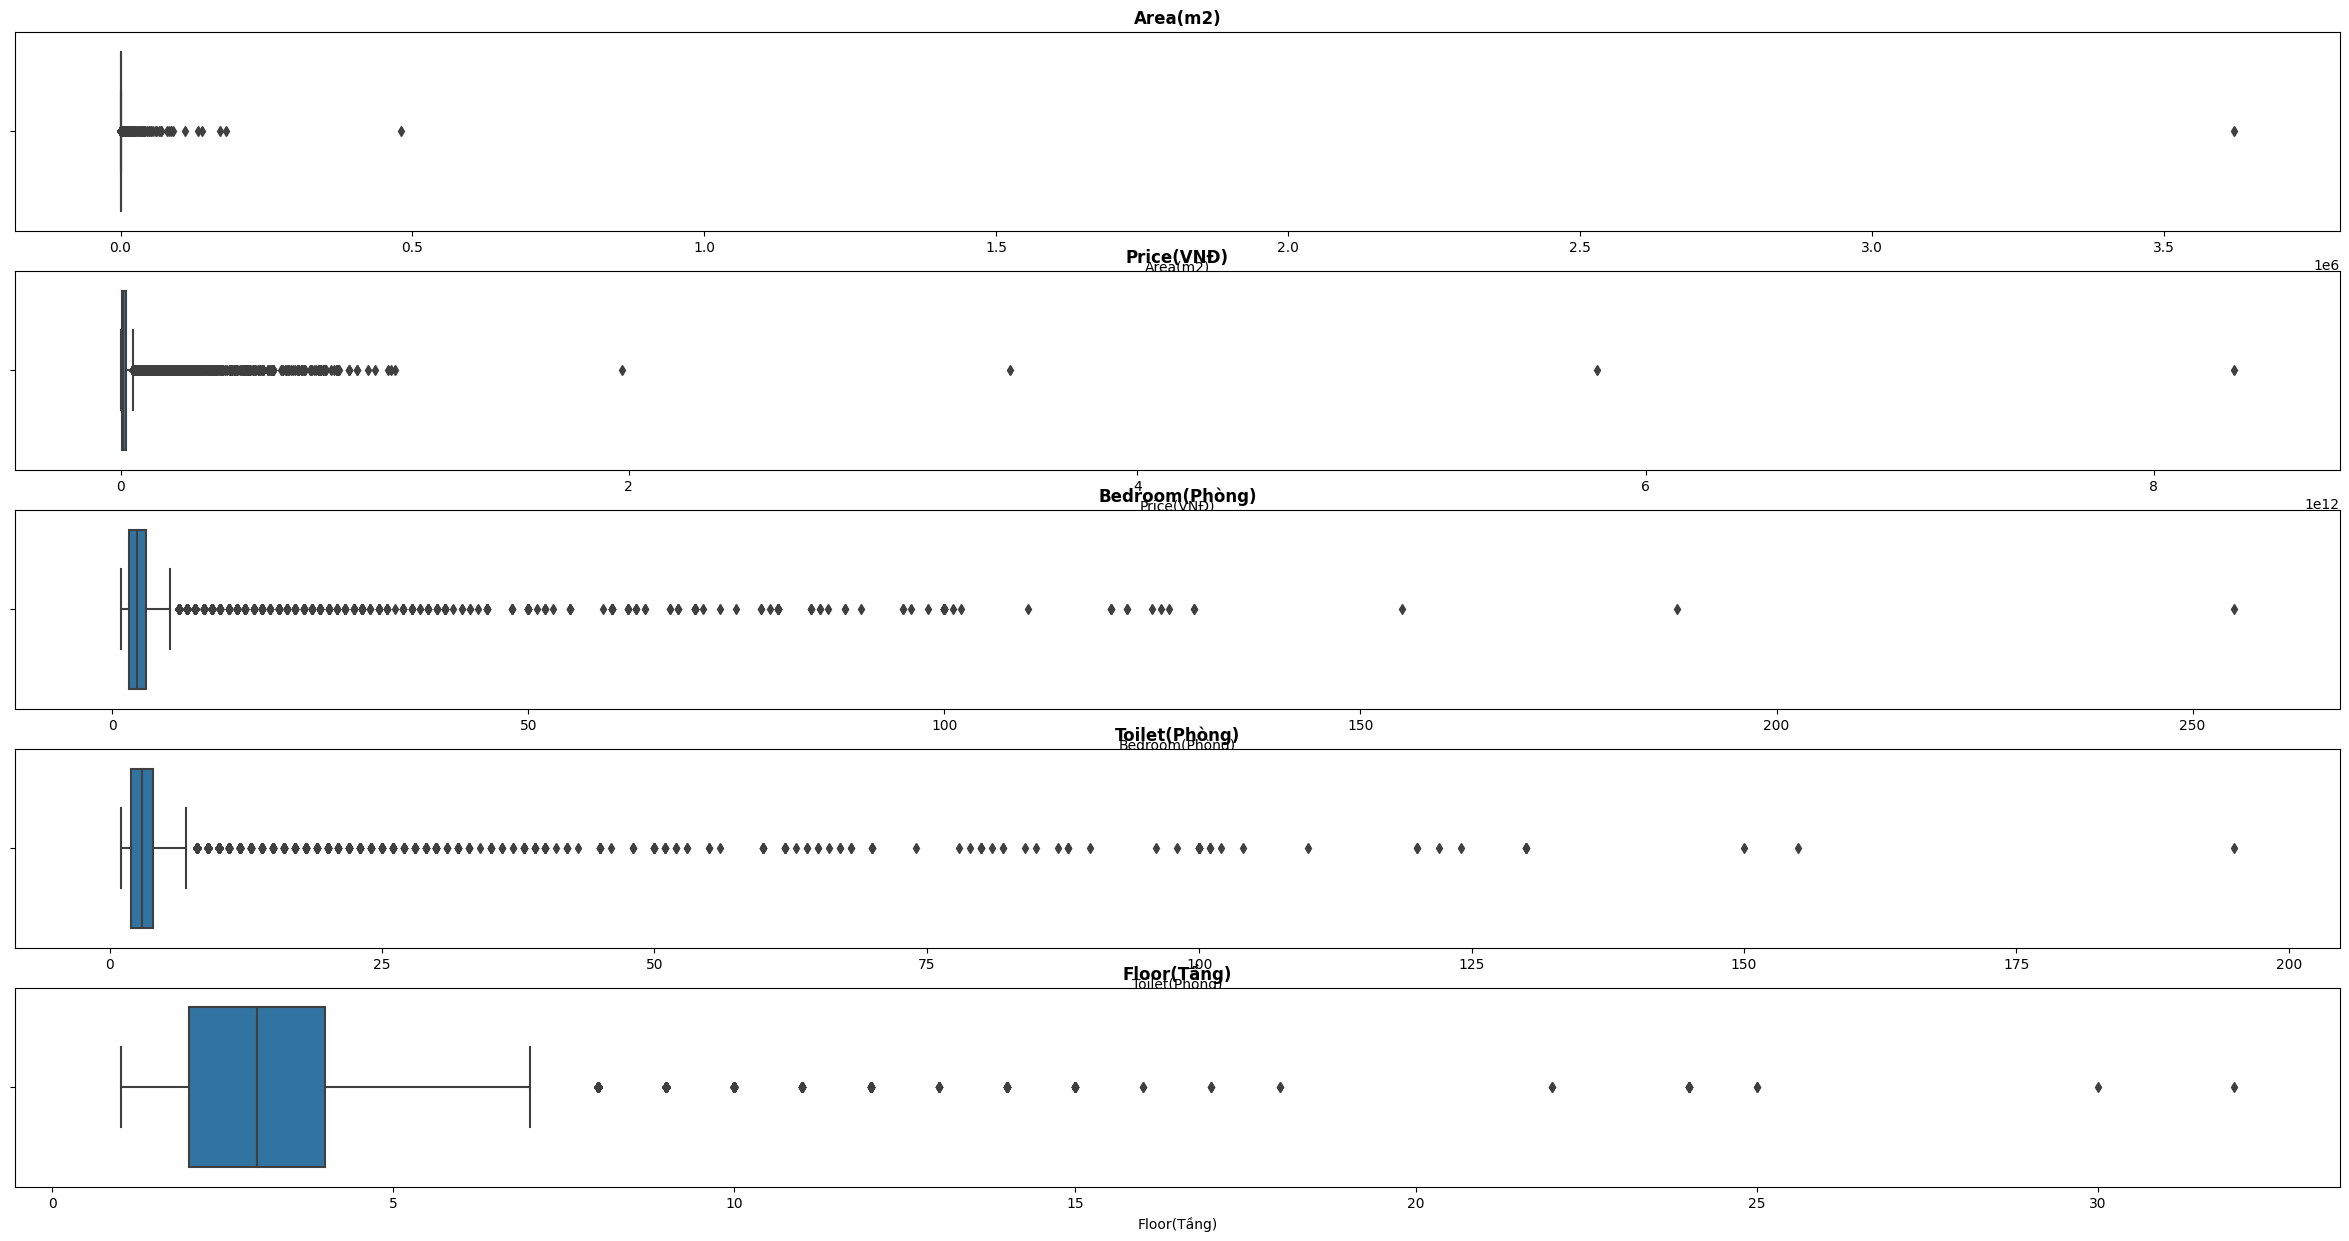

In [825]:
columns_to_plot = ['Area(m2)', 'Price(VNĐ)', 'Bedroom(Phòng)', 'Toilet(Phòng)', 'Floor(Tầng)']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(30, 15))


for i, column in enumerate(columns_to_plot):
    sns.boxplot(x = real_estate_for_sale_df[column], ax=axes[i])
    axes[i].set_title(column, fontweight = 'bold')

plt.show()

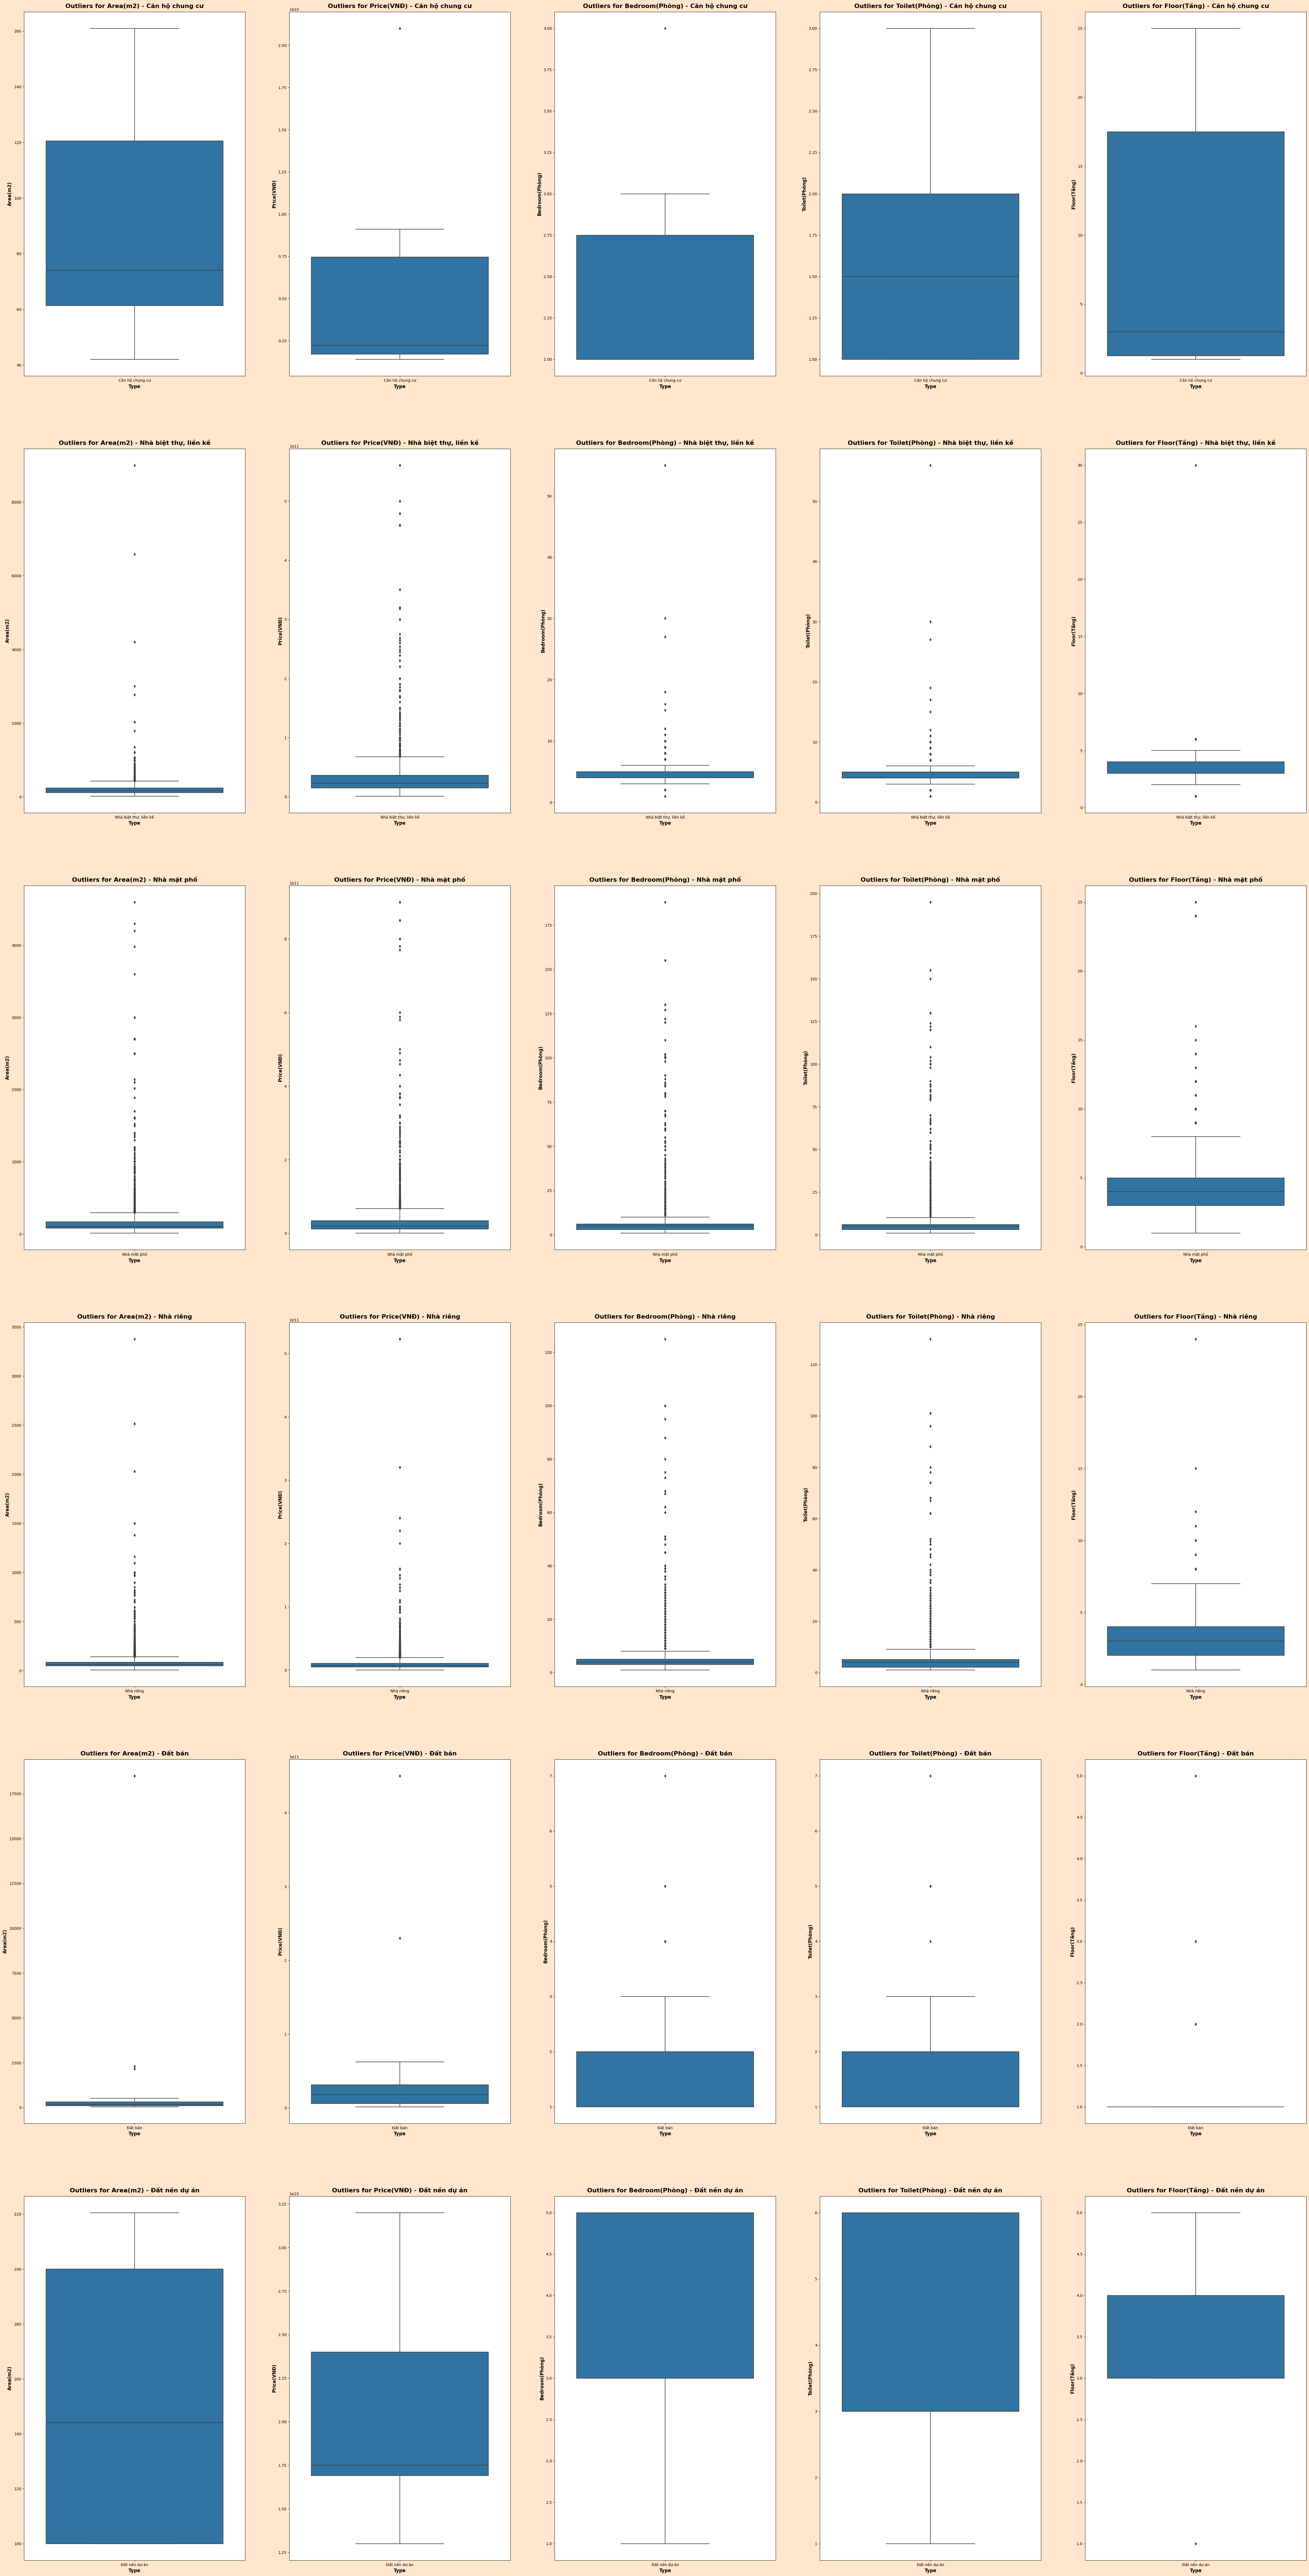

In [826]:
columns_to_plot = ['Area(m2)', 'Price(VNĐ)', 'Bedroom(Phòng)', 'Toilet(Phòng)', 'Floor(Tầng)']
grouped_by_type_df = real_estate_for_sale_df.dropna().groupby('Type')
fig, axes = plt.subplots(nrows= 6, ncols=5, figsize=(60, 120))

index = 0
for key, data in grouped_by_type_df:
    for column in columns_to_plot:

        ax = axes[index // 5, index % 5]
        
        sns.boxplot(x = data['Type'], y = data[column], ax = ax)
        ax.set_title(f"Outliers for {column} - {key}", fontsize = 16, fontweight = 'bold', pad = 10)
        ax.set_xlabel("Type", fontsize = 12, fontweight = 'bold')
        ax.set_ylabel(column, fontsize = 12, fontweight = 'bold')
        index += 1

fig = plt.gcf()
fig.set_facecolor('#ffe6cc')
plt.show()

By these box plot, we just see that here are lots of outliers that occur in our dataset. These outliers may have negative effects to our future analysis, also our model won't get a high performance. so, in the easiest way, we just drop all the ouliers.

First, let's take a look at the types `Đất bán` and `Đất nền dự án`, normally, these type will not have the value in column `Bedroom`, `Toilet` and `Floor`, so just keep all the samples in these type that have no value in these column 

In [827]:

filtered_df = real_estate_for_sale_df[real_estate_for_sale_df['Type'].isin(['Đất bán', 'Đất nền dự án']) &
                                        ((real_estate_for_sale_df['Bedroom(Phòng)'] > 0) |
                                        (real_estate_for_sale_df['Toilet(Phòng)'] > 0) |
                                        (real_estate_for_sale_df['Floor(Tầng)'] > 0))]

real_estate_for_sale_df.drop(filtered_df.index, inplace=True)

In [828]:
real_estate_for_sale_df[real_estate_for_sale_df['Type'] == 'Căn hộ chung cư']['Area(m2)'].max()

1030.0

Okay, now we have remove all the outliers for the type `Đất bán` and `Đất nền dự án`, next, we will move to more complicated columns

- With other types, we can see that there are values that is more far from the medium. So will implement the way to detect and remove the ouliers for each real estate type.

In [829]:

# columns_to_detect = ['Area(m2)', 'Price(VNĐ)', 'Bedroom(Phòng)', 'Toilet(Phòng)', 'Floor(Tầng)']

# cleaned_real_estate_df = real_estate_for_sale_df.copy()
# grouped_by_type_df = cleaned_real_estate_df.dropna().groupby('Type')

# for key, data in grouped_by_type_df:
#     indices = []

#     for column in columns_to_detect:
#         column_values = data[column].dropna().to_numpy()

#         q1 = np.percentile(column_values, 25)
#         q3 = np.percentile(column_values, 75)
#         iqr = q3 - q1

#         lower_threshold = q1 - 1.5 * iqr
#         upper_threshold = q3 + 1.5 * iqr

#         outliers_mask = (data[column] < lower_threshold) | (data[column] > upper_threshold)

#         indices.extend(data[~outliers_mask].index)
        
#     indices = list(set(indices))
#     cleaned_real_estate_df.loc[indices, columns_to_detect] = data.loc[indices, columns_to_detect]

# cleaned_real_estate_df['Price(VNĐ)'].isna().sum()


columns_to_detect = ['Area(m2)', 'Price(VNĐ)', 'Bedroom(Phòng)', 'Toilet(Phòng)', 'Floor(Tầng)']

cleaned_real_estate_df = real_estate_for_sale_df.copy()

for column in columns_to_detect:
    column_values = cleaned_real_estate_df[column].dropna().to_numpy()

    q1 = np.percentile(column_values, 25)
    q3 = np.percentile(column_values, 75)
    iqr = q3 - q1

    lower_threshold = q1 - 1.5 * iqr
    upper_threshold = q3 + 1.5 * iqr

    outliers_mask = (cleaned_real_estate_df[column] < lower_threshold) | (cleaned_real_estate_df[column] > upper_threshold)

    cleaned_real_estate_df = cleaned_real_estate_df[~outliers_mask]


cleaned_real_estate_df['Price(VNĐ)'].isna().sum()

5297

### **2.6 Fill in the missing values**


First, check the missing ratio now

In [830]:
missing_ratios_df = cleaned_real_estate_df.agg(missing_ratio).to_frame()
missing_ratios_df

,0
Type,0.000000
Area(m2),0.000000
Price(VNĐ),12.083676
Bedroom(Phòng),31.985126
Toilet(Phòng),36.134684
Floor(Tầng),56.088603
Furniture,0.000000
Legal,0.000000
Posting date,0.000000
District,0.000000


As we discuss above, with the `Bedroom`, `Toilet`, `Floor` columns are not the attribute of some type of real estate. so with  `Đất nền dự án`, `Đất bán`, `Trang trại, khu nghỉ dưỡng` , the `Nan` will be replaced by `-1`, with the others, I also group it by the category and fill by the mean of each.

In [831]:
replace_nan_types = ['Đất nền dự án', 'Đất bán', 'Trang trại, khu nghỉ dưỡng']
columns = ['Bedroom(Phòng)', 'Toilet(Phòng)', 'Floor(Tầng)']

for col in columns:
    mask = cleaned_real_estate_df['Type'].isin(replace_nan_types)
    cleaned_real_estate_df.loc[mask, col] = cleaned_real_estate_df.loc[mask, col].fillna(-1)
    cleaned_real_estate_df.loc[~mask , col] = cleaned_real_estate_df.loc[ ~mask, col].fillna(round(cleaned_real_estate_df.loc[~mask, col].mean(),0))

In [832]:
missing_ratios_df = cleaned_real_estate_df.agg(missing_ratio).to_frame()
missing_ratios_df

,0
Type,0.000000
Area(m2),0.000000
Price(VNĐ),12.083676
Bedroom(Phòng),0.000000
Toilet(Phòng),0.000000
Floor(Tầng),0.000000
Furniture,0.000000
Legal,0.000000
Posting date,0.000000
District,0.000000


Finally, les't check out our dataset again

In [833]:
cleaned_real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43836 entries, 0 to 55045
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Type            43836 non-null  object        
 1   Area(m2)        43836 non-null  float64       
 2   Price(VNĐ)      38539 non-null  float64       
 3   Bedroom(Phòng)  43836 non-null  float64       
 4   Toilet(Phòng)   43836 non-null  float64       
 5   Floor(Tầng)     43836 non-null  float64       
 6   Furniture       43836 non-null  object        
 7   Legal           43836 non-null  object        
 8   Posting date    43836 non-null  datetime64[ns]
 9   District        43836 non-null  object        
 10  Project         43836 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(5)
memory usage: 4.0+ MB


The result look good, now stored it into a new file and begin something fun with it

### Save the processed data

In [834]:
cleaned_real_estate_df.to_csv("../Data/cleaned_real_estate_for_sale.csv", index= False)